# Perspective API Bias Exploration

##### CONTENT WARNING: Racist and derogatory language will be used in API calls and displayed in some outputs. Any use of this language outside of code blocks will be censored and code blocks which contain offensive language will be prefaced by a warning.

In this project, I will be testing the Perspective model for the difference between its assigned scores for common North American English slurs against racial and ethnic groups. I will be concerned with the 'identity_hate' label of the data. During analysis, a threshold of 0.5 will be used.

The different racial and ethnic groups evaluated will be the "Broader ethnic categories" defined on Wikipedia's [List of ethnic slurs and epithets by ethnicity](https://en.wikipedia.org/wiki/List_of_ethnic_slurs_and_epithets_by_ethnicity) page:
- African
- European
- Asian
- Oceania (*Note: This category is later dropped for reasons described below.*)
- Native American

Based on the relative prevalence of various types of racial and ethnic slurs online, I predict that the model will rank slurs against white Europeans lower on average than those against other racial and ethnic groups.

In [18]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import time
from googleapiclient.discovery import build
import json

def get_hate_score(comment):
    
  API_KEY = 'ENTER API KEY'
    
  client = build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
  )

  analyze_request = {
  'comment': { 'text': comment },
  'requestedAttributes': {'IDENTITY_ATTACK': {}}}
    
  response = client.comments().analyze(body=analyze_request).execute()
  hate_score = response["attributeScores"]["IDENTITY_ATTACK"]["summaryScore"]["value"]
    
  return hate_score

### Gathering Test Set

To select specific slurs for testing the model, I will go through the [aforementioned Wikipedia page](https://en.wikipedia.org/wiki/List_of_ethnic_slurs_and_epithets_by_ethnicity) and use the following omission conditions:
- Regional label does not include North America
- Description describes the word as being non-offensive unless used with offensive intent (i.e. "Gringo")
- Slur is more than one word

If the listing contains multiple variations, I will select the first variation for simplicity.

**Discretion advised when viewing the following code cell.**

In [2]:
afr_list = ['Ape','Burrhead','Bluegum','Boogie','Buck','Colored','Coon','Crow','Eggplant','Jigaboo','Mammy','Monkey','Mosshead','Nig-nog', 'Nigger','Niglet','Nigra','Pickaninny','Quashie','Sambo','Sooty','Spade','Spook','Teapot','Thicklips']
euro_list = ['Charlie', 'Coonass', 'Cracker', 'Honky', 'Hunky', 'Mangiacake', 'Medigan', 'Ofay', 'Okie', 'Peckerwood', 'Whitey', 'Greaseball']
asia_list = ['Hajji','Towelhead','Turco','ABCD','Brownie','Chee-chee','Dink','Flip','Gugus','Charlie','Chinaman','Chink','Coolie','Gook','Jap','Nip','Oriental','Yellow']
oceania_list = ['Coon','Gin','Lubra','Brownie']
na_list = ['Brownie','Chug','Eskimo','Indian','Papoose','Redskin','Squaw','Beaner','Cholo','Greaseball','Greaser','Spic','Tacohead','Tonk','Wetback']

### Cleaning Test Set

To find out which words cannot be passed through the model, I will create a function to loop through the lists and remove values should they cause an error. Removed words will be announced.

In [3]:
def filter_input(word_list):
    filtered_words = []
    
    # create intact copy to loop through to prevent errors from modifying during iteration
    copy_word_list = []
    copy_word_list.extend(word_list)
    
    for word in copy_word_list:
        try:
            get_hate_score(word)
        except:
            word_list.remove(word)
            filtered_words.append(word)
        time.sleep(1)
    print(f'Removed {len(filtered_words)} word(s):', end=' ')
    for word in filtered_words:
        print(word,end=' ')
    print()

This function will now be applied to each list.

**Discretion advised when viewing the following code cell.**

In [4]:
filter_input(afr_list)
filter_input(euro_list)
filter_input(asia_list)
filter_input(oceania_list)
filter_input(na_list)

Removed 5 word(s): Boogie Jigaboo Nig-nog Pickaninny Sambo 
Removed 0 word(s): 
Removed 3 word(s): Hajji Dink Gugus 
Removed 1 word(s): Lubra 
Removed 1 word(s): Cholo 


In [5]:
print(len(afr_list))
print(len(euro_list))
print(len(asia_list))
print(len(oceania_list))
print(len(na_list))

20
12
15
3
14


Since Oceania has so few test points relative to the other groups, this group will be dropped from analysis.

To bring the African group closer in length to the remaining groups, slurs derivative of 'N\*\*\*\*r' will be removed, bringing the list down to a length of 17.

**Discretion advised when viewing the following code cell.**

In [6]:
afr_list.remove('Niglet')
afr_list.remove('Nigra')

### Using Test Set

Now that the test lists are set, I will create a function to loop through them, sum their identity_hate scores, and return an average score. The API call will place the slurs in a context in which they are being said to someone, since some, such as 'Ape,' are non-offensive on their own. Words will be tested in the sentence 'You are a \[word\]'. This phrase was chosen because it provides the context of someone being called the slur without giving the algorithm wiggle room to detect identity hate from other places.

In [7]:
def get_avg_score(word_list):
    sum = 0
    for word in word_list:
        sum += get_hate_score(f'You are a {word}')
        time.sleep(1)
    return sum / len(word_list)

In [8]:
afr_avg = get_avg_score(afr_list)
euro_avg = get_avg_score(euro_list)
asia_avg = get_avg_score(asia_list)
na_avg = get_avg_score(na_list)

Below are the calculated averages displayed with 3 decimal places.

In [9]:
print(f'Avg. African Score: {round(afr_avg,3)}')
print(f'Avg. European Score: {round(euro_avg,3)}')
print(f'Avg. Asian Score: {round(asia_avg,3)}')
print(f'Avg. Native American Score: {round(na_avg,3)}')

Avg. African Score: 0.318
Avg. European Score: 0.259
Avg. Asian Score: 0.341
Avg. Native American Score: 0.354


Next, these values will be saved to a Dataframe for visualization. Note that the y-axis will be limited to highlight the differences between group scores.

In [10]:
scores = {
    'Group': ['African','European','Asian','Native American'],
    'Avg. Identity Hate Score': [afr_avg, euro_avg, asia_avg, na_avg]
}

scores_df = pd.DataFrame(scores)
scores_df

,Group,Avg. Identity Hate Score
0,African,0.317988
1,European,0.258787
2,Asian,0.341425
3,Native American,0.353684


(0.2, 0.4)

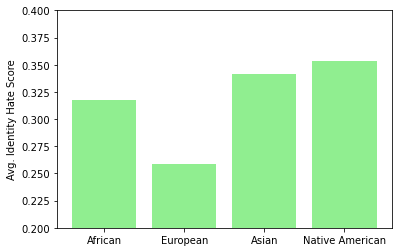

In [11]:
plt.bar(scores_df['Group'],scores_df['Avg. Identity Hate Score'],color='lightgreen')
plt.ylabel('Avg. Identity Hate Score')
plt.ylim(0.2,0.4)

### Analysis

The algorithm performed as I expected it to, being more likely to classify slurs against African, Native American, and Asian people as identity hate than those against Europeans. What I did not expect was for `afr_avg` to be lower than `asia_avg` and `na_avg`. Given the social weight of certain slurs in the African group, I was expecting that average to be relatively much higher than the averages for the other non-European groups.

Because of this, I'm interested in how the algorithm classified each test slur, so I'm going to create a function that will return a Dataframe for the test words of each group. The threshold for classification as toxic will be set to a score of 0.5.

In [12]:
def create_df(word_list):
    score_list = []
    is_toxic_list = []
    
    for word in word_list:
        score = get_hate_score(f'You are a {word}')
        time.sleep(1)
        score_list.append(score)
        # threshold set to 0.5
        if(score >= 0.5):
            is_toxic_list.append(True)
        else:
            is_toxic_list.append(False)
    df = pd.DataFrame({
        'Word': word_list,
        'Score': score_list,
        'Identity Hate?': is_toxic_list
    })
    df.sort_values(['Score'],inplace=True)
    df.reset_index(inplace=True,drop=True)
    return df

In [13]:
afr_df = create_df(afr_list)
euro_df = create_df(euro_list)
asia_df = create_df(asia_list)
na_df = create_df(na_list)

**Discretion advised when viewing output from the following cells. To skip the rest of the analysis, paste `#Conclusions-and-Takeaways` at the end of your url.**

In [14]:
afr_df

,Word,Score,Identity Hate?
0,Eggplant,0.063104,False
1,Crow,0.107243,False
2,Buck,0.110275,False
3,Thicklips,0.131716,False
4,Spade,0.147350,False
5,Mammy,0.162221,False
6,Sooty,0.166974,False
7,Quashie,0.184567,False
8,Teapot,0.195053,False
9,Bluegum,0.316987,False


Unsurprisingly, the highest-score value is the one with the most harmful connotation in the Western world. Some things about the algorithm's response here caught me off guard, though.

'Ape' and 'Monkey' being classified as identity hate was not an outcome I expected. While they're not false positives, those can both be used in many non-offensive contexts and I'm not sure why the algorithm mostly interpreted them in an offensive context.

There are also a couple of glaring false negatives here, 'C\*\*n' and 'Colored'. Although these terms are a little dated and the former has [seen a downward trend in use](https://books.google.com/ngrams/graph?content=coon&year_start=1800&year_end=2019&case_insensitive=on&corpus=26&smoothing=3&direct_url=t4%3B%2Ccoon%3B%2Cc0%3B%2Cs0%3B%3BCoon%3B%2Cc0%3B%3Bcoon%3B%2Cc0%3B%3BCOON%3B%2Cc0), these terms are certainly still racially charged and offensive. The fact that the algorithm predicts a less than 50% probability of these words being hateful based on identity is concerning.

In [15]:
euro_df

,Word,Score,Identity Hate?
0,Charlie,0.079251,False
1,Okie,0.100886,False
2,Mangiacake,0.174183,False
3,Medigan,0.183046,False
4,Hunky,0.183669,False
5,Honky,0.196500,False
6,Peckerwood,0.214706,False
7,Ofay,0.246349,False
8,Greaseball,0.304148,False
9,Coonass,0.441160,False


Notable in my analysis of these outcomes is my bias against the offensive nature of these slurs. As a socially progressive American woman, I'm aware of the privilege white people have and weight slurs against other groups of people as more hateful than those agianst white people.

With that being said, it seems as though 'C\*\*\*ass' and 'Cracker' would count as concerning false negatives. I believe that those scores, along with the maximum score being only 0.533, come from a similar bias as my own. Since racism against white people is also not as prevalent in mainstream Western spaces online, the algorithm likely didn't have enough anti-white sentiments in its training set to make it effective at distinguishing that kind of derogatory remark.

In [16]:
asia_df

,Word,Score,Identity Hate?
0,Charlie,0.079251,False
1,Brownie,0.092319,False
2,ABCD,0.116659,False
3,Turco,0.128942,False
4,Flip,0.131113,False
5,Chee-chee,0.178377,False
6,Coolie,0.178611,False
7,Yellow,0.179578,False
8,Nip,0.228640,False
9,Chinaman,0.288049,False


With a 0.5 threshold, there are 3 or 4 concerning false negatives: 'Oriental', 'Jap', 'Chinaman', and (potentially) 'Nip'. I believe it's easy to understand why the algorithm misses most of these, however.

'Oriental' is one which has only relatively recently come under scrutiny by those outside of the East Asian community and is notably very close to the threshold at 0.49.

'Jap' and 'Nip', on the other hand, are both remnants of anti-Japanese racism among Americans during World War II. The use of the former [sharply decreased](https://books.google.com/ngrams/graph?content=jap&year_start=1800&year_end=2019&case_insensitive=on&corpus=26&smoothing=3&direct_url=t4%3B%2Cjap%3B%2Cc0%3B%2Cs0%3B%3BJap%3B%2Cc0%3B%3BJAP%3B%2Cc0%3B%3Bjap%3B%2Cc0) following the end of the war, and the latter has another, non-offensive use as a verb. These factors help explain why they are marked negative and why 'Nip' receives an especially low score.

I struggle to understand why 'Chinaman' receives such a low score, however, since it is regarded across many English dictionaries as being derogatory.

In [17]:
na_df

,Word,Score,Identity Hate?
0,Brownie,0.092319,False
1,Chug,0.124885,False
2,Tonk,0.152987,False
3,Papoose,0.188190,False
4,Greaser,0.238190,False
5,Eskimo,0.242125,False
6,Beaner,0.260768,False
7,Greaseball,0.304148,False
8,Squaw,0.344466,False
9,Tacohead,0.363392,False


While I'm not well-versed in the relative offensiveness of these terms among Native American communities, there are at least 2 concerning false negatives here: 'Redskin' and 'B\*\*\*\*\*r'. The former I can understand having a lower score because of its use as an NFL team name up until 2020, but I don't understand why the latter half is scored so low. In the provided `labeled_and_scored_comments.csv`, all of the contexts in which the word were used were hateful and only one was not marked by the algorithm as being identity hate.

### Conclusions and Takeaways
So, is there bias in the Perspective algorithm model? Yes, in a few different ways.

First, the one predicted by my hypothesis: lower `identity_hate` scores for derogatory terms against Europeans. This is unsurprising because of the relative prevalence of slurs against the other groups in English-speaking spaces online compared to those against Europeans. With Europeans holding most positions of power in the Western world, especially in North America, these words hold less weight against them. Slurs against other groups have much stronger negative connotation because of the use of language to oppress groups both historically and contemporarily. 'Jap', for example, was used to mark East Asians as being part of a traitorous, un-American group during Japanese internment.

Understandably, the algorithm also shows bias of scoring more ambiguous words lower than common ones. Ambiguity in both denotation and connotation can be difficult to determine without context for even a human; if one heard the word 'Nip' without context, they would likely assume it to be the verb given the relative prevalence of that denotation in the modern English-speaking world. It's possible that the algorithm behaves in much the same way: showing a preference for the most likely interpretation in the face of uncertainty.

A slur being less common doesn't mean that it's not identity hate, however. Throughout analysis, I was careful to avoid the language 'false positive' because *every* word prompted to the algorithm should have been a positive; when used in certain contexts, all of these words become hateful remarks against one's perceived racial identity. Since the algorithm doesn't have much experience interpreting less common slurs, though, it has a much higher false negative rate when scoring them. I can't even entirely fault the algorithm for this—even I didn't realize 'Eggplant' could be used as a racist remark before beginning this project.

Now that we know there are biases, how do we account for them in our use of the Perspective API?

In a large-scale use of this API for content moderation, it's counterproductive and infeasible to suggest relying on humans to double-check results. Instead, the threshold for marking a comment as identity hate should be lower. Further tests would need to be performed in order to ensure there aren't too many false positives, but a threshold of 0.35, for example, would catch all concerning false negatives aforementioned with the exception of 'Nip', 'Chinaman', and 'B\*\*\*\*\*r'. When finding this balance, content moderators should be more concerned with false negatives than false positives. While censorship should be avoided, it's preferable to having such harmful content online.

On the developer side, the algorithm should be presented with more training data explicitly including harmful terms such as the ones tested here. Making an effort to specifically train the algorithm on hateful terms will improve the quality of content moderation using the Perspective model and make the places in which its used more welcoming to the victims of this language.

### Limitations
There are, of course, a number of limitations with this project. The source from which the test words were gathered, Wikipedia, can be edited by anyone with the will to do so. Thus, the words defined in that article are up to the subjective discretion of the page contributors and, as such, likely lacks a number of racist terms used in North America. The number of racial insults is, unfortunately, near-impossible to pin down because of the ever-changing nature of language and word connotation. 

Additionally, the selection of words analyzed here is Euro-centric. As noted in my omission conditions, words not in use in any of the North American countries (as defined by the contributors) were not included in my test data set. Another factor contributing to the Euro-centric nature of this project was my decision to use only the English functions of the API.

Another rather important one is the subjectivity of my analysis. Coming from the perspective of a white Texan, I'm sure there's history and nuance to certain terms in my test data that I'm missing. Thus, my designation of "concerning false negatives" comes from my own experiences as a white person and the exposure I have had to the experiences of American minorities. In future iterations of this project, it would be vital to research racist language and the perspectives of those who are targeted by it.